<a href="https://colab.research.google.com/github/Venuram/Machine-Learning-ML/blob/master/Quora_question_pair_detection_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h3> Authorizing google drive files to be used in Google Colab

In [0]:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

In [0]:
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [0]:
downloaded = drive.CreateFile({'id':'1kaiyKGUvYfEnZ9jckosLcLD0NO-K07Hz'}) # replace the id with id of file you want to access
downloaded.GetContentFile('train.csv')

In [0]:
downloaded1 = drive.CreateFile({'id':'1Ac_aEvVeP6pJnhCnql5uj7ovi-1_prn7'}) # replace the id with id of file you want to access
downloaded1.GetContentFile('nlp_features_train.csv')

In [0]:
downloaded2 = drive.CreateFile({'id':'197VLUQUd2Wa8jEsRlBWxEOVTFDl3mRh_'}) # replace the id with id of file you want to access
downloaded2.GetContentFile('train_p.txt')

In [0]:
downloaded3 = drive.CreateFile({'id':'1izFvfUOc80sbiUlqUO5f7N1sw4TkNmSb'}) # replace the id with id of file you want to access
downloaded3.GetContentFile('df_fe_without_preprocessing_train.csv')

In [0]:
import sys
sys.path.append('path/to/module')

In [0]:
sys.executable

'C:\\Users\\Dell\\Anaconda3\\python.exe'

<h3> Importing libraries and functions used to analyze the data

In [0]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import distance
%matplotlib inline
import os
import gc
import plotly.offline as py
py.init_notebook_mode(connected=True)
from nltk.corpus import stopwords
import nltk
nltk.download('stopwords')
from nltk.stem import PorterStemmer
from bs4 import BeautifulSoup
import plotly.graph_objs as go
import plotly.tools as tls
import re
import warnings
warnings.filterwarnings("ignore")
from fuzzywuzzy import fuzz
from wordcloud import STOPWORDS, WordCloud

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


<h3> Reading data and understanding some basic information about the given data

In [0]:
df = pd.read_csv('train.csv')
df.shape[0]
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 404290 entries, 0 to 404289
Data columns (total 6 columns):
id              404290 non-null int64
qid1            404290 non-null int64
qid2            404290 non-null int64
question1       404289 non-null object
question2       404288 non-null object
is_duplicate    404290 non-null int64
dtypes: int64(4), object(2)
memory usage: 18.5+ MB


In [0]:
df.head()

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0


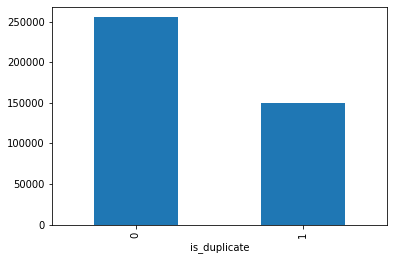

In [0]:
df.groupby("is_duplicate")['id'].count().plot.bar()

The above plot depicts the number of question pairs that are duplicate and non-duplicate.

0 - Non-Duplicate
1 - Duplicate.

In [0]:
print('Total number of question pairs for training:\n {}'.format(len(df)))

Total number of question pairs for training:
 404290


In [0]:
print('Percentage of question pairs that are not similar or belongs to class 0 {}'. format(100 - round(df['is_duplicate'].mean()*100,2)))
print('Percentage of question pairs that are similar or belongs to class 1 {}'. format(round(df['is_duplicate'].mean()*100,2)))

Percentage of question pairs that are not similar or belongs to class 0 63.08
Percentage of question pairs that are similar or belongs to class 1 36.92


In [0]:
qids = pd.Series(df['qid1'].tolist() + df['qid2'].tolist())
uniq_qus = len(np.unique(qids))
print('No of unique questions {}'.format(uniq_qus))
qus_id_morethan_once = np.sum(qids.value_counts() > 1)
print('No of unique questions that appear more than once: {}'.format(qus_id_morethan_once))
print('Max no of times a single qus is repeated {}'.format(max(qids.value_counts())))

No of unique questions 537933
No of unique questions that appear more than once: 111780
Max no of times a single qus is repeated 157


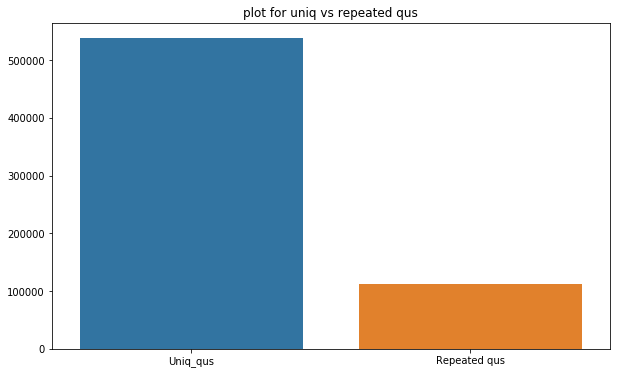

In [0]:
x = ['Uniq_qus', 'Repeated qus']
y = [uniq_qus, qus_id_morethan_once]

plt.figure(figsize=(10,6))
plt.title('plot for uniq vs repeated qus')
sns.barplot(x,y)
plt.show()

Plot represents the new features that we built for analysis point of view. 

i.e. Unique questions and Repeated Questions.

In [0]:
#check whether there exist any duplicate pairs

pair_duplicate = df[['qid1','qid2','is_duplicate']].groupby(['qid1','qid2']).count().reset_index()
print("The number of duplicate question pair: {}". format((pair_duplicate).shape[0] - df.shape[0]))

The number of duplicate question pair: 0


<h2> No of occurences of each question

Max no of times a single qus is repeated 157


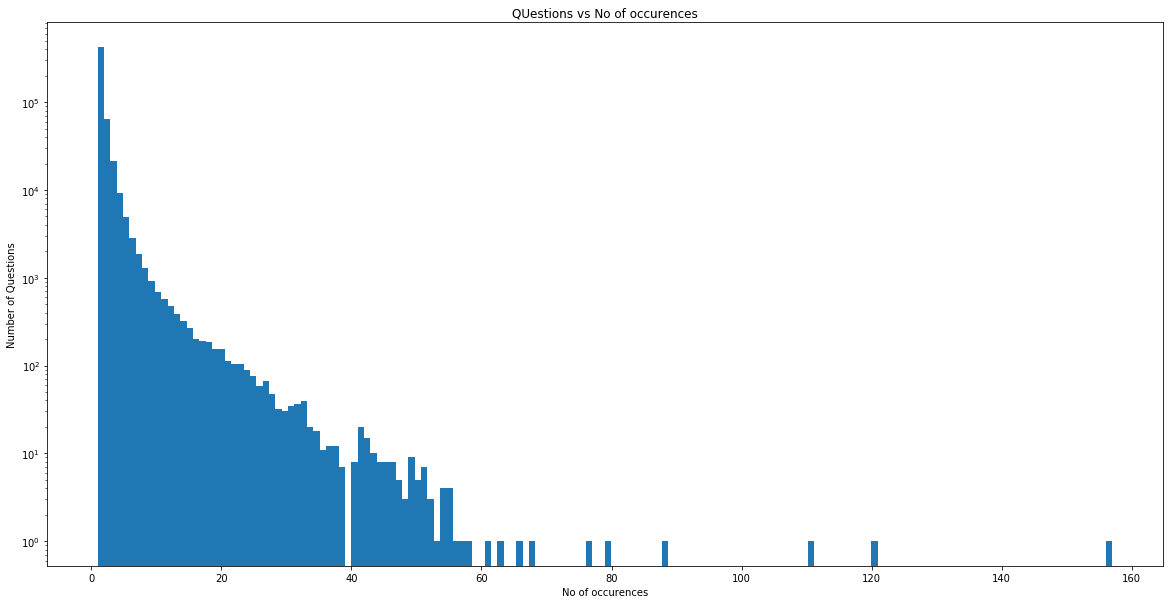

In [0]:
plt.figure(figsize=(20, 10))
plt.hist(qids.value_counts(), bins=160)
plt.yscale('log', nonposy = 'clip')
plt.title('QUestions vs No of occurences')
plt.xlabel('No of occurences')
plt.ylabel('Number of Questions')
print('Max no of times a single qus is repeated {}'.format(max(qids.value_counts())))

In [0]:
#Checking the null values for rows in dataset and listing out rows having null values.
nan_rows = df[df.isnull().any(1)]
print(nan_rows)

            id  ...  is_duplicate
105780  105780  ...             0
201841  201841  ...             0
363362  363362  ...             0

[3 rows x 6 columns]


<h2>There are 3 rows having nan values in question 1 and question 2 fields.</h2>

In [0]:
#Filling the missing null values.

df = df.fillna('')
nan_rows = df[df.isnull().any(1)]
print(nan_rows)

Empty DataFrame
Columns: [id, qid1, qid2, question1, question2, is_duplicate]
Index: []


<h2> Constructing different required features that helps for better modelling

freq_qid1 = Frequency of qid1's

freq_qid2 = Frequency of qid2's 

q1len = Length of q1

q2len = Length of q2

q1_n_words = Number of words in Question 1

q2_n_words = Number of words in Question 2

word_Common = (Number of common unique words in Question 1 and Question 2)

word_Total =(Total num of words in Question 1 + Total num of words in Question 2)

word_share = (word_common)/(word_Total)

freq_q1+freq_q2 = sum total of frequency of qid1 and qid2 

freq_q1-freq_q2 = absolute difference of frequency of qid1 and qid2 

In [0]:
if os.path.isfile('df_fe_without_preprocessing_train.csv'):
    df = pd.read_csv('df_fe_without_preprocessing_train.csv', encoding='latin-1')
else:
    df['freq_qid1'] = df.groupby('qid1')['qid1'].transform('count')
    df['freq_qid2'] = df.groupby('qid2')['qid2'].transform('count')
    df['q1len'] = df['question1'].str.len()
    df['q2len'] = df['question2'].str.len()
    df['q1_n_words'] = df['question1'].apply(lambda row : len(row.split(' ')))
    df['q2_n_words'] = df['question2'].apply(lambda row : len(row.split(' ')))
    
    def common_word(row):
        w1 = set(map(lambda word: word.lower().strip(), row['question1'].split(' ')))
        w2 = set(map(lambda word: word.lower().strip(), row['question2'].split(' ')))
        return 1.0 * len(w1 & w2)
    df['word_common'] = df.apply(common_word, axis=1)
    
    def total_word(row):
        w1 = set(map(lambda word: word.lower().strip(), row['question1'].split(' ')))
        w2 = set(map(lambda word: word.lower().strip(), row['question2'].split(' ')))
        return 1.0 * (len(w1) + len(w2))
    df['total_word'] = df.apply(total_word, axis=1)
    
    def word_share(row):
        w1 = set(map(lambda word: word.lower().strip(), row['question1'].split(' ')))
        w2 = set(map(lambda word: word.lower().strip(), row['question2'].split(' ')))
        return 1.0 * len(w1 & w2)/(len(w1) + len(w2))
    df['word_share'] = df.apply(word_share, axis=1)
    
    df['freq_q1 + q2'] = df['freq_qid1'] + df['freq_qid2']
    df['freq_q1 - q2'] = abs(df['freq_qid1'] - df['freq_qid2'])
    
    df.to_csv('df_fe_without_preprocessing_train.csv', index=False)

df.head()
#total word count is different which should be 14+12=26 and here it is 23.

,id,qid1,qid2,question1,question2,is_duplicate,freq_qid1,freq_qid2,q1len,q2len,q1_n_words,q2_n_words,word_Common,word_Total,word_share,freq_q1+q2,freq_q1-q2
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0,1,1,66,57,14,12,10.0,23.0,0.434783,2,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0,4,1,51,88,8,13,4.0,20.0,0.200000,5,3
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0,1,1,73,59,14,10,4.0,24.0,0.166667,2,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0,1,1,50,65,11,9,0.0,19.0,0.000000,2,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0,3,1,76,39,13,7,2.0,20.0,0.100000,4,2


In [0]:
print('Minimum length of questions in q1_n_words:', min(df['q1_n_words']))
print('Minimum length of questions in q2_n_words:', min(df['q2_n_words']))
print('Number of questions with minimum length [questions1]', df[df['q1_n_words'] == 1].shape[0])
print('Number of questions with minimum length [questions2]', df[df['q2_n_words'] == 1].shape[0])    

Minimum length of questions in q1_n_words: 1
Minimum length of questions in q2_n_words: 1
Number of questions with minimum length [questions1] 67
Number of questions with minimum length [questions2] 24


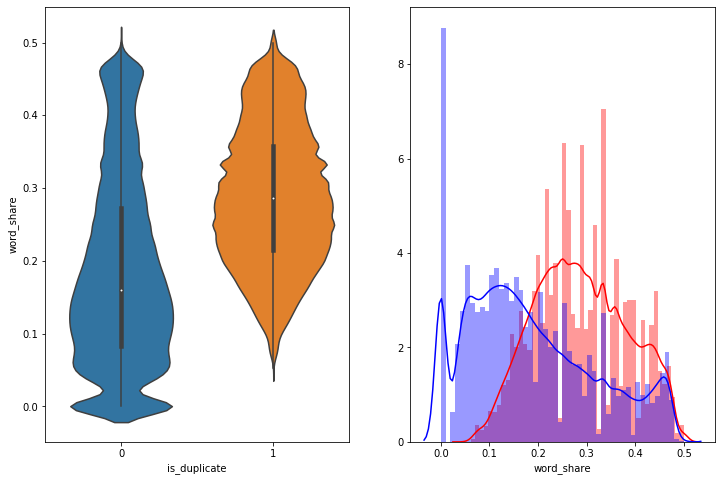

In [0]:
#PLotting violin plot and histogram - PDFs of the class label
plt.figure(figsize = (12, 8))
plt.subplot(1,2,1)
sns.violinplot(x = 'is_duplicate', y = 'word_share', data = df[0:])

plt.subplot(1,2,2)
sns.distplot(df[df['is_duplicate'] == 1.0]['word_share'][0:], label = '1', color = 'red') #questions are duplicate
sns.distplot(df[df['is_duplicate'] == 0.0]['word_share'][0:], label = '0', color = 'blue') #questions not duplicate
plt.show()

Plotting violin plot and histogram - PDFs of the class label

In [0]:
safe_div = 0.0001
stop_words = stopwords.words('english')

def preprocess(x):
    x = str(x).lower()
    x = x.replace('000,000','m').replace(',000','k').replace("′", "'").replace("’", "'")\
                           .replace("won't", "will not").replace("cannot", "can not").replace("can't", "can not")\
                           .replace("n't", " not").replace("what's", "what is").replace("it's", "it is")\
                           .replace("'ve", " have").replace("i'm", "i am").replace("'re", " are")\
                           .replace("he's", "he is").replace("she's", "she is").replace("'s", " own")\
                           .replace("%", " percent ").replace("₹", " rupee ").replace("$", " dollar ")\
                           .replace("€", " euro ").replace("'ll", " will")
    x = re.sub(r'([0-9]+)000000', r'\1m', x)
    x = re.sub(r'[0-9]+000', r'/1k', x)
    
    porter = PorterStemmer()
    pattern = re.compile('\W')
    
    if type(x) == type(''):
        x = re.sub(pattern, ' ', x)
        
    if type(x) == type(''):
        x = porter.stem(x)
        ex1 = BeautifulSoup()
        x = ex1.get_text()
        
    return x

In [0]:
def get_token_features(q1, q2):
    token_features = [0.0]*10 #doubt
    
    #converting the questions into tokens:
    q1_tokens = q1.split()
    q2_tokens = q2.split()
    
    if len(q1_tokens) == 0 or len(q2_tokens) == 0:
        return token_features
    
    #get non-stop words in questions
    q1_words = set([word for word in q1_tokens if word not in stop_words])
    q2_words = set([word for word in q2_tokens if word not in stop_words])
    
    #get stop words in questions
    q1_stops = set([word for word in q1_tokens if word in stop_words])
    q2_stops = set([word for word in q2_tokens if word in stop_words])
    
    #to get common non stopwords in questions
    common_word_count = len(q1_words.intersection(q2_words))
    
    #get common stopwords from question pair
    common_stop_words_count = len(q1_stops.intersections(q2_stops))
    
    #common tokens of both questions
    common_token_count = len(set(q1_tokens.intersection(q2_tokens)))
    
    token_features[0] = common_word_count / (min(len(q1_words), len(q2_words)) + SAFE_DIV)
    token_features[1] = common_word_count / (max(len(q1_words), len(q2_words)) + SAFE_DIV)
    token_features[2] = common_stop_count / (min(len(q1_stops), len(q2_stops)) + SAFE_DIV)
    token_features[3] = common_stop_count / (max(len(q1_stops), len(q2_stops)) + SAFE_DIV)
    token_features[4] = common_token_count / (min(len(q1_tokens), len(q2_tokens)) + SAFE_DIV)
    token_features[5] = common_token_count / (max(len(q1_tokens), len(q2_tokens)) + SAFE_DIV)
    
    #last words of both questions are same or not
    token_features[6] = int(q1_tokens[-1] == q2_tokens[-1])
    
    #first words of both questions are same or not
    token_features[7] = int(q1_tokens[0] == q2_tokens[0])
    
    #Difference between length of the tokens
    token_features[8] = abs(len(q1_tokens) - len(q2_tokens))
    
    #avg length of both questions
    token_features[9] = abs(len(q1_tokens) + len(q2_tokens))/2
    
    return token_features

#to get the longest common substring:

def get_longest_substring(a, b):
    strs = list(distance.lcsubstrings(a, b))
    if len(strs) == 0:
        return 0
    else:
        return len(strs[0]) / min(len(0), len(b) + 1)

def extract_features(df):
    df['question1'] = df['question1'].fillna('').apply(preprocess)
    df['question2'] = df['question2'].fillna('').apply(preprocess)

    print('token features')
    
    #Merging features with dataset
    
    token_features = df.apply(lambda x: get_token_features(x['question1'], x['question2']), axis = 1)
    
    df["cwc_min"]       = list(map(lambda x: x[0], token_features))
    df["cwc_max"]       = list(map(lambda x: x[1], token_features))
    df["csc_min"]       = list(map(lambda x: x[2], token_features))
    df["csc_max"]       = list(map(lambda x: x[3], token_features))
    df["ctc_min"]       = list(map(lambda x: x[4], token_features))
    df["ctc_max"]       = list(map(lambda x: x[5], token_features))
    df["last_word_eq"]  = list(map(lambda x: x[6], token_features))
    df["first_word_eq"] = list(map(lambda x: x[7], token_features))
    df["abs_len_diff"]  = list(map(lambda x: x[8], token_features))
    df["mean_len"]      = list(map(lambda x: x[9], token_features))
   
    print('fuzzy features')
    
    df['token_set_ratio'] = df.apply(lambda x: fuzz.token_set_ratio(x['question1'], x['question2']), axis = 1)
    df['token_sort_ratio'] = df.apply(lambda x: fuzz.token_sort_ratio(x['question1'], x['question2']), axis = 1)
    df['fuzz_ratio'] = df.apply(lambda x: fuzz.QRatio(x['question1'], x['question2']), axis = 1)
    df['fuzz_partial_ratio'] = df.apply(lambda x: fuzz.partial_ratio(x['question1'], x['question2']), axis = 1)
    df['longest_substring'] = df.apply(lambda x: get_longest_substring(x['question1'], x['question2']), axis = 1)
    return df

In [0]:
#Read the nlp_features_train csv file created with new features developed from the existing features.
df1 = pd.read_csv('nlp_features_train.csv',encoding='latin1')
df1.head(2)

,id,qid1,qid2,question1,question2,is_duplicate,cwc_min,cwc_max,csc_min,csc_max,ctc_min,ctc_max,last_word_eq,first_word_eq,abs_len_diff,mean_len,token_set_ratio,token_sort_ratio,fuzz_ratio,fuzz_partial_ratio,longest_substr_ratio
0,0,1,2,what is the step by step guide to invest in sh...,what is the step by step guide to invest in sh...,0,0.999980,0.833319,0.999983,0.999983,0.916659,0.785709,0.0,1.0,2.0,13.0,100,93,93,100,0.982759
1,1,3,4,what is the story of kohinoor koh i noor dia...,what would happen if the indian government sto...,0,0.799984,0.399996,0.749981,0.599988,0.699993,0.466664,0.0,1.0,5.0,12.5,86,63,66,75,0.596154


In [0]:
df_duplicate = df[df['is_duplicate'] == 1]
dfp_nonduplicate = df[df['is_duplicate'] == 0]

# Converting 2d array of q1 and q2 and flatten the array: like {{1,2},{3,4}} to {1,2,3,4}
p = np.dstack([df_duplicate["question1"], df_duplicate["question2"]]).flatten()
n = np.dstack([dfp_nonduplicate["question1"], dfp_nonduplicate["question2"]]).flatten()

print ("Number of data points in class 1 (duplicate pairs) :",len(p))
print ("Number of data points in class 0 (non duplicate pairs) :",len(n))

#Saving the np array into a text file
np.savetxt('train_p.txt', p, delimiter=' ', fmt='%s')
np.savetxt('train_n.txt', n, delimiter=' ', fmt='%s')

Number of data points in class 1 (duplicate pairs) : 298526
Number of data points in class 0 (non duplicate pairs) : 510054


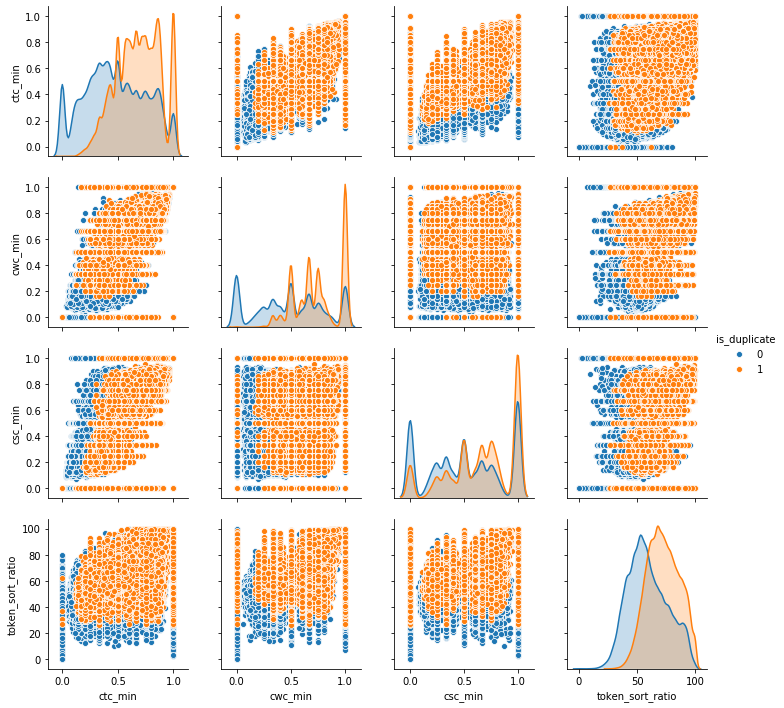

In [0]:
n = df.shape[0]
sns.pairplot(df1[['ctc_min', 'cwc_min', 'csc_min', 'token_sort_ratio', 'is_duplicate']][0:n], hue='is_duplicate', vars=['ctc_min', 'cwc_min', 'csc_min', 'token_sort_ratio'])
plt.show()

<h3> The pair plot clearly shows that the new feature "token_sort_ratio" has some linearly separable perception for both duplicate and non-duplicate question pairs and we plot distribution of the same below.

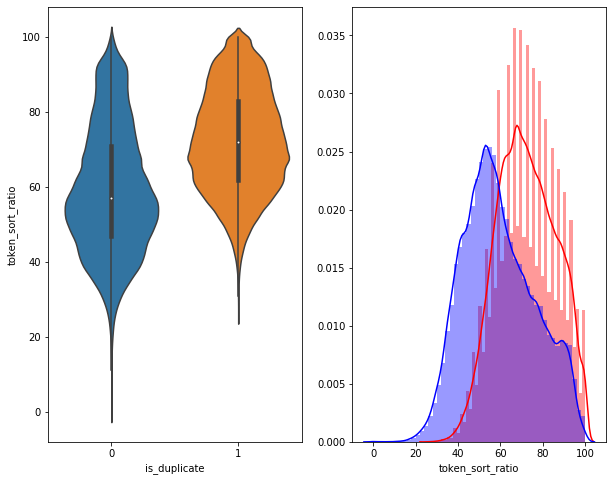

In [0]:
# Distribution of the token_sort_ratio
plt.figure(figsize=(10, 8))

plt.subplot(1,2,1)
sns.violinplot(x = 'is_duplicate', y = 'token_sort_ratio', data = df1[0:] , )

plt.subplot(1,2,2)
sns.distplot(df1[df1['is_duplicate'] == 1.0]['token_sort_ratio'][0:] , label = "1", color = 'red')
sns.distplot(df1[df1['is_duplicate'] == 0.0]['token_sort_ratio'][0:] , label = "0" , color = 'blue' )
plt.show()

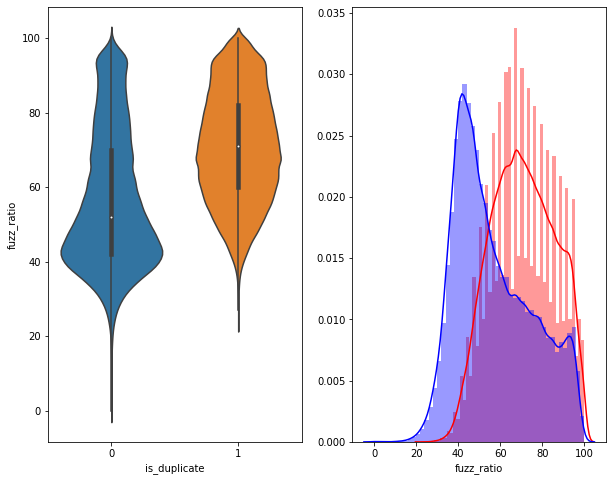

In [0]:
plt.figure(figsize=(10, 8))

plt.subplot(1,2,1)
sns.violinplot(x = 'is_duplicate', y = 'fuzz_ratio', data = df1[0:] , )

plt.subplot(1,2,2)
sns.distplot(df1[df1['is_duplicate'] == 1.0]['fuzz_ratio'][0:] , label = "1", color = 'red')
sns.distplot(df1[df1['is_duplicate'] == 0.0]['fuzz_ratio'][0:] , label = "0" , color = 'blue' )
plt.show()

Using TSNE for Dimentionality reduction for 15 Features(Generated after cleaning the data) to 3 dimention

In [0]:
from sklearn.preprocessing import MinMaxScaler

dfp_subsampled = df1[0:5000]
X = MinMaxScaler().fit_transform(dfp_subsampled[['cwc_min', 'cwc_max', 'csc_min', 'csc_max' , 'ctc_min' , 'ctc_max' , 'last_word_eq', 'first_word_eq' , 'abs_len_diff' , 'mean_len' , 'token_set_ratio' , 'token_sort_ratio' ,  'fuzz_ratio' , 'fuzz_partial_ratio' , 'longest_substr_ratio']])
y = dfp_subsampled['is_duplicate'].values

In [0]:
from sklearn.manifold import TSNE
tsne2d = TSNE(
    n_components=2,
    init='random', # pca
    random_state=101,
    method='barnes_hut',
    n_iter=1000,
    verbose=2,
    angle=0.5
).fit_transform(X)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 5000 samples in 0.016s...
[t-SNE] Computed neighbors for 5000 samples in 0.416s...
[t-SNE] Computed conditional probabilities for sample 1000 / 5000
[t-SNE] Computed conditional probabilities for sample 2000 / 5000
[t-SNE] Computed conditional probabilities for sample 3000 / 5000
[t-SNE] Computed conditional probabilities for sample 4000 / 5000
[t-SNE] Computed conditional probabilities for sample 5000 / 5000
[t-SNE] Mean sigma: 0.116557
[t-SNE] Computed conditional probabilities in 0.305s
[t-SNE] Iteration 50: error = 80.9720154, gradient norm = 0.0451379 (50 iterations in 1.759s)
[t-SNE] Iteration 100: error = 70.4389801, gradient norm = 0.0098959 (50 iterations in 1.383s)
[t-SNE] Iteration 150: error = 68.6479568, gradient norm = 0.0059423 (50 iterations in 1.383s)
[t-SNE] Iteration 200: error = 67.8050308, gradient norm = 0.0040715 (50 iterations in 1.398s)
[t-SNE] Iteration 250: error = 67.3068771, gradient norm = 0.0031636

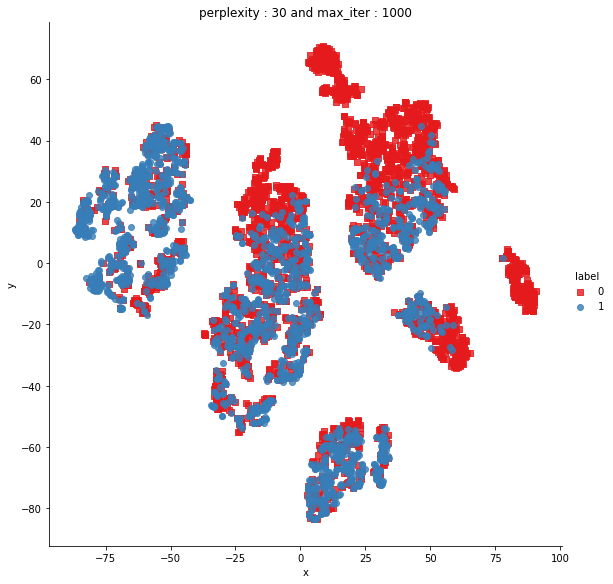

In [0]:
df = pd.DataFrame({'x':tsne2d[:,0], 'y':tsne2d[:,1] ,'label':y})

# Draw the plot in appropriate place in the grid.
sns.lmplot(data=df, x='x', y='y', hue='label', fit_reg=False, size=8,palette="Set1",markers=['s','o'])
plt.title("perplexity : {} and max_iter : {}".format(30, 1000))
plt.show()

In [0]:
from sklearn.manifold import TSNE
tsne3d = TSNE(
    n_components=3,
    init='random', # pca
    random_state=101,
    method='barnes_hut',
    n_iter=1000,
    verbose=2,
    angle=0.5
).fit_transform(X)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 5000 samples in 0.015s...
[t-SNE] Computed neighbors for 5000 samples in 0.352s...
[t-SNE] Computed conditional probabilities for sample 1000 / 5000
[t-SNE] Computed conditional probabilities for sample 2000 / 5000
[t-SNE] Computed conditional probabilities for sample 3000 / 5000
[t-SNE] Computed conditional probabilities for sample 4000 / 5000
[t-SNE] Computed conditional probabilities for sample 5000 / 5000
[t-SNE] Mean sigma: 0.116557
[t-SNE] Computed conditional probabilities in 0.285s
[t-SNE] Iteration 50: error = 80.3825836, gradient norm = 0.0316220 (50 iterations in 9.055s)
[t-SNE] Iteration 100: error = 69.1291580, gradient norm = 0.0034171 (50 iterations in 4.412s)
[t-SNE] Iteration 150: error = 67.6390839, gradient norm = 0.0017523 (50 iterations in 3.908s)
[t-SNE] Iteration 200: error = 67.0798187, gradient norm = 0.0011316 (50 iterations in 3.900s)
[t-SNE] Iteration 250: error = 66.7545319, gradient norm = 0.0010951

In [0]:
df = pd.read_csv("train.csv")

df['question1'] = df['question1'].apply(lambda x: str(x))
df['question2'] = df['question2'].apply(lambda x: str(x))

In [0]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
# merge texts
questions = list(df['question1']) + list(df['question2'])

tfidf = TfidfVectorizer(lowercase=False, )
tfidf.fit_transform(questions)

# dict key:word and value:tf-idf score
word2tfidf = dict(zip(tfidf.get_feature_names(), tfidf.idf_))

In [0]:
import spacy
from tqdm import tqdm

# en_vectors_web_lg, which includes over 1 million unique vectors.
nlp = spacy.load('en_core_web_sm')

vecs1 = []
# tqdm is used to print the progress bar
for qu1 in tqdm(list(df['question1'])):
    doc1 = nlp(qu1) 
    # 384 is the number of dimensions of vectors 
    mean_vec1 = np.zeros([len(doc1), len(doc1[0].vector)])
    for word1 in doc1:
        # word2vec
        vec1 = word1.vector
        # fetch df score
        try:
            idf = word2tfidf[str(word1)]
        except:
            idf = 0
        # compute final vec
        mean_vec1 += vec1 * idf
    mean_vec1 = mean_vec1.mean(axis=0)
    vecs1.append(mean_vec1)
df['q1_feats_m'] = list(vecs1)


100%|██████████| 404290/404290 [52:10<00:00, 129.14it/s]


In [0]:
vecs2 = []
for qu2 in tqdm(list(df['question2'])):
    doc2 = nlp(qu2) 
    mean_vec2 = np.zeros([len(doc2), len(doc2[0].vector)])
    for word2 in doc2:
        # word2vec
        vec2 = word2.vector
        # fetch df score
        try:
            idf = word2tfidf[str(word2)]
        except:
            #print word
            idf = 0
        # compute final vec
        mean_vec2 += vec2 * idf
    mean_vec2 = mean_vec2.mean(axis=0)
    vecs2.append(mean_vec2)
df['q2_feats_m'] = list(vecs2)

100%|██████████| 404290/404290 [52:32<00:00, 128.24it/s]


In [0]:
print(df.columns)

Index(['id', 'qid1', 'qid2', 'question1', 'question2', 'is_duplicate',
       'q1_feats_m', 'q2_feats_m'],
      dtype='object')


prepro_features_train.csv (Simple Preprocessing Feartures)

nlp_features_train.csv (NLP Features)

In [0]:
import os
if os.path.isfile('nlp_features_train.csv'):
    dfnlp = pd.read_csv("nlp_features_train.csv",encoding='latin-1')
else:
    print("download nlp_features_train.csv from drive or run previous notebook")

if os.path.isfile('df_fe_without_preprocessing_train.csv'):
    dfppro = pd.read_csv("df_fe_without_preprocessing_train.csv",encoding='latin-1')
else:
    print("download df_fe_without_preprocessing_train.csv from drive or run previous notebook")

In [0]:
df.head(2)

,id,qid1,qid2,question1,question2,is_duplicate,q1_feats_m,q2_feats_m
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0,"[211.12986397743225, -144.68305885791779, -68....","[151.2685260772705, -127.01316797733307, -31.5..."
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0,"[144.124685049057, -114.0124841555953, -111.71...","[152.02309501171112, -44.95538953691721, -103...."


In [0]:
df1 = dfnlp.drop(['qid1','qid2','question1','question2'],axis=1)
df2 = dfppro.drop(['qid1','qid2','question1','question2','is_duplicate'],axis=1)
df3 = df.drop(['qid1','qid2','question1','question2','is_duplicate'],axis=1)
df3_q1 = pd.DataFrame(df3.q1_feats_m.values.tolist(), index= df1.index)
df3_q2 = pd.DataFrame(df3.q2_feats_m.values.tolist(), index= df3.index)

In [0]:
# dataframe of nlp features
df1.head(2)

,id,is_duplicate,cwc_min,cwc_max,csc_min,csc_max,ctc_min,ctc_max,last_word_eq,first_word_eq,abs_len_diff,mean_len,token_set_ratio,token_sort_ratio,fuzz_ratio,fuzz_partial_ratio,longest_substr_ratio
0,0,0,0.999980,0.833319,0.999983,0.999983,0.916659,0.785709,0.0,1.0,2.0,13.0,100,93,93,100,0.982759
1,1,0,0.799984,0.399996,0.749981,0.599988,0.699993,0.466664,0.0,1.0,5.0,12.5,86,63,66,75,0.596154


In [0]:
# data before preprocessing 
df2.head(2)

,id,freq_qid1,freq_qid2,q1len,q2len,q1_n_words,q2_n_words,word_Common,word_Total,word_share,freq_q1+q2,freq_q1-q2
0,0,1,1,66,57,14,12,10.0,23.0,0.434783,2,0
1,1,4,1,51,88,8,13,4.0,20.0,0.200000,5,3


In [0]:
# Questions 1 tfidf weighted word2vec
df3_q1.head(4)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95
0,211.129864,-144.683059,-68.811247,-153.662141,-89.931593,2.311301,136.743747,50.449112,-64.150964,56.627526,70.148884,-19.668092,3.220435,-108.875797,61.560220,-83.830943,43.621516,114.621134,19.361845,116.752304,-110.904795,-104.655793,70.776944,266.029300,57.959328,94.104574,188.227136,-47.905627,40.152197,303.801049,53.047279,-1.010889,-166.091202,-30.814132,25.290403,22.995724,-68.330367,83.621365,-110.773904,38.606964,...,56.725948,-4.609248,-39.738396,196.880060,-49.277630,-169.070418,179.595977,-59.518374,9.319959,70.611649,-62.301108,95.722271,-93.060989,184.719507,39.616421,-53.016748,78.754825,103.623331,128.853304,200.878963,9.418689,72.890495,-155.806943,-124.938086,-44.380726,-99.382469,-189.679104,96.286983,3.966004,-48.648795,33.176593,-102.487002,144.595747,50.614258,-21.385940,36.385601,-70.999820,4.141466,-131.379525,71.884573
1,144.124685,-114.012484,-111.716694,-104.885038,-88.238478,16.441834,58.238013,102.095138,6.026966,178.498497,-22.003573,10.791894,-187.942327,-131.886144,53.476555,-120.873004,117.119611,209.002639,104.745780,82.015269,-67.366032,-152.282135,28.448090,196.723074,-41.048402,-27.583167,129.732189,-69.869688,60.635265,273.106264,128.834101,46.690212,13.195704,-35.669981,160.486912,89.043474,-112.731840,100.945506,75.614349,-70.645671,...,71.028835,83.799450,-201.194100,-35.934346,-120.343935,55.350533,132.726299,10.883411,-35.670799,80.078389,71.389960,-133.973739,-3.731305,-46.763965,9.160930,129.628878,72.256272,141.452563,2.176436,-8.807140,70.308457,-18.918405,3.955878,-109.197110,-135.522543,-104.224510,-238.053444,48.332183,63.791688,29.296462,67.386291,22.131810,40.210794,0.254035,98.600184,-36.436027,-123.609728,71.788337,-15.374614,-10.503958
2,81.757898,-142.184507,0.559867,-104.660084,-84.156631,22.515110,115.521661,50.436953,-111.740923,51.713310,-50.512388,3.029880,-101.605073,-124.537681,129.567171,-35.142460,66.920581,110.851539,19.244706,140.933759,-136.412045,-131.366463,180.824239,265.986679,7.573772,53.054180,32.404845,-40.288709,6.982227,178.159372,44.963908,-28.145689,-135.032690,-62.944629,105.237449,98.974474,-2.260294,89.970612,-12.494589,41.387744,...,54.768804,-20.600327,-71.733865,29.386397,-0.938005,-100.231185,88.304147,-78.633304,-31.012009,3.021985,-16.485088,92.326060,-111.473802,185.897607,-9.068853,-58.997920,29.293201,157.078950,100.438641,85.974096,-20.489402,-9.727843,-50.745659,-140.199320,55.960929,-2.548514,-141.338526,76.257999,-56.288086,29.954749,61.731855,-49.822495,107.080594,-11.431423,-40.667739,-26.771786,-12.482071,1.764694,-100.330459,148.061206
3,-126.651922,-59.747160,-67.763201,-138.114731,-101.038699,88.148523,-22.912261,85.941426,27.784233,50.810650,-64.085183,-1.990449,3.103386,31.170661,-73.118845,58.233994,-90.755115,25.278119,-50.849782,-56.944923,-157.596517,-50.896747,146.592772,103.181320,34.274884,85.545554,68.271444,61.822074,-75.803873,121.756886,-3.517907,11.074592,-110.385570,93.482724,62.452370,67.962872,81.283337,55.851768,-35.195467,-63.609127,...,46.228646,10.242953,6.355290,112.181208,-25.390530,113.004712,-33.447529,7.206453,76.463504,29.184045,78.303415,-40.678027,-60.314249,-83.142049,-7.011845,-37.584972,-141.788783,34.829037,30.101367,-30.264566,-74.522968,-102.248504,144.190824,163.620801,-7.952212,5.446319,-63.540029,17.786646,-76.093066,-21.006171,117.847457,-13.044505,-1.643167,78.158408,23.748127,12.945961,-8.807293,123.360096,64.057049,-24.943289


In [0]:
# Questions 2 tfidf weighted word2vec
df3_q2.head(4)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95
0,151.268526,-127.013168,-31.546286,-142.905807,-97.249094,9.485758,106.682259,36.754201,-36.541905,53.162199,57.798781,-34.539162,19.626286,-75.324668,73.160855,-75.943612,30.795570,89.649668,7.456815,104.710572,-89.255365,-92.446700,71.610017,237.232877,40.115430,64.232808,166.004508,-41.567455,45.424107,279.448449,19.880162,14.994184,-108.337972,-9.586054,14.642593,21.764268,-52.430637,66.028016,-79.345246,19.708894,...,63.459020,-6.311536,-21.760468,194.737497,-47.763672,-144.616534,153.968820,-40.945057,37.548652,41.647766,-73.519272,70.209004,-75.368039,156.349642,44.208612,-23.547798,69.883078,97.310878,125.984050,197.091046,-2.107076,76.050946,-122.895941,-84.888849,-35.973324,-82.526090,-160.285621,54.893650,-10.232465,-50.744309,28.763393,-108.306631,131.115633,42.530936,-14.726235,15.763654,-59.729557,-9.563384,-99.812549,57.643628
1,152.023095,-44.955390,-103.559249,-128.467601,-118.567610,44.577916,137.906144,26.984746,-78.328355,86.576880,-38.312126,-82.055423,-168.921524,-136.148574,13.828562,-67.919932,160.479399,222.381787,-54.984025,-42.837671,-59.291782,-163.251981,114.825004,158.406455,-47.784958,-71.926232,112.437219,-115.157175,85.453291,403.408967,150.566185,77.195489,31.371965,32.786803,257.702179,93.863829,-156.245194,133.518596,157.003578,-128.381275,...,112.687227,-15.581937,-264.369218,33.627755,-155.186128,128.838932,262.957780,24.868980,-23.468657,61.935278,30.281989,-97.138215,-6.737601,42.201864,11.454692,-7.226339,-55.998572,196.762083,56.418867,-24.148336,-27.707474,-44.380209,15.944973,-124.367160,-62.534570,-224.950485,-267.903211,97.299487,-55.366655,5.517342,117.588061,5.239833,56.622487,92.054093,141.063301,-30.466199,-25.418970,87.120086,-23.594506,7.936921
2,4.930220,-29.029581,-117.808812,-98.332275,-19.064096,-9.867805,141.808202,91.269564,50.727205,12.816846,22.755020,-61.095737,-96.926685,-107.221417,42.588726,4.387927,53.386532,68.774950,-31.636927,85.388483,-141.393116,-26.997678,114.337558,208.297437,-44.740873,28.577437,119.373177,-76.732412,5.204106,157.927217,8.645347,31.185043,-170.102781,3.163748,59.886647,-9.321814,-18.559612,10.939464,50.168880,-4.392919,...,20.251093,-12.533245,-145.274685,133.128196,-35.894020,16.601313,51.298792,-111.557811,-93.723447,21.036835,36.570152,76.936519,-135.184749,116.425427,-17.774938,-36.601950,-9.800254,154.311148,28.385146,157.381362,-0.202910,-4.943891,42.938207,-35.604127,-60.052574,-93.064247,-163.215306,125.819704,29.723694,-52.851137,128.699958,17.433420,58.203339,88.642941,-84.962783,71.462342,-10.853897,-59.501685,-99.425331,95.334773
3,-6.951929,-44.951731,-17.343082,-61.444452,-7.469152,16.942014,95.049250,-2.631600,-13.050916,-28.038393,28.901785,-37.439560,-96.333290,-54.729787,-49.528354,43.265676,-8.688619,34.214650,-4.497978,27.962733,-54.832524,-4.874446,90.271060,46.998673,43.779531,-39.946557,34.865285,14.978698,-9.556619,170.290531,68.847898,59.973762,-42.757395,82.483636,-2.758815,20.919674,-5.603089,-26.432023,-43.471311,-15.716046,...,14.860271,-30.326556,-137.106395,33.379686,13.509829,-7.759193,40.972374,-52.179422,-9.143602,-14.430484,94.654058,84.587984,12.978830,22.456387,16.013255,-64.677682,-11.589900,22.045068,11.084187,79.668263,-2.703853,-42.298158,60.377843,-21.285794,28.196993,-41.508922,-125.404171,-4.990982,-28.640298,-53.830178,70.475260,-31.174277,86.080290,49.967751,25.750448,-27.612377,24.050802,-3.504152,-46.115810,56.242265


In [0]:
print("Number of features in nlp dataframe :", df1.shape[1])
print("Number of features in preprocessed dataframe :", df2.shape[1])
print("Number of features in question1 w2v  dataframe :", df3_q1.shape[1])
print("Number of features in question2 w2v  dataframe :", df3_q2.shape[1])
print("Number of features in final dataframe  :", df1.shape[1]+df2.shape[1]+df3_q1.shape[1]+df3_q2.shape[1])

Number of features in nlp dataframe : 17
Number of features in preprocessed dataframe : 12
Number of features in question1 w2v  dataframe : 96
Number of features in question2 w2v  dataframe : 96
Number of features in final dataframe  : 221


In [0]:
# storing the final features to csv file
if not os.path.isfile('final_features.csv'):
    df3_q1['id']=df1['id']
    df3_q2['id']=df1['id']
    df1  = df1.merge(df2, on='id',how='left')
    df2  = df3_q1.merge(df3_q2, on='id',how='left')
    result  = df1.merge(df2, on='id',how='left')
    result.to_csv('final_features.csv')

In [0]:
downloaded5 = drive.CreateFile({'id':'1sUAhAGawmbUy1gmRIvn16M4tbMUI-ZUV'}) # replace the id with id of file you want to access
downloaded5.GetContentFile('final_features.csv')

In [0]:
df5 = pd.read_csv('final_features.csv')
df5.head()

,Unnamed: 0,id,is_duplicate,cwc_min,cwc_max,csc_min,csc_max,ctc_min,ctc_max,last_word_eq,first_word_eq,abs_len_diff,mean_len,token_set_ratio,token_sort_ratio,fuzz_ratio,fuzz_partial_ratio,longest_substr_ratio,freq_qid1,freq_qid2,q1len,q2len,q1_n_words,q2_n_words,word_Common,word_Total,word_share,freq_q1+q2,freq_q1-q2,0_x,1_x,2_x,3_x,4_x,5_x,6_x,7_x,8_x,9_x,10_x,...,344_y,345_y,346_y,347_y,348_y,349_y,350_y,351_y,352_y,353_y,354_y,355_y,356_y,357_y,358_y,359_y,360_y,361_y,362_y,363_y,364_y,365_y,366_y,367_y,368_y,369_y,370_y,371_y,372_y,373_y,374_y,375_y,376_y,377_y,378_y,379_y,380_y,381_y,382_y,383_y
0,0,0,0,0.999980,0.833319,0.999983,0.999983,0.916659,0.785709,0.0,1.0,2.0,13.0,100,93,93,100,0.982759,1,1,66,57,14,12,10.0,23.0,0.434783,2,0,121.929927,100.083900,72.497894,115.641800,-48.370870,34.619058,-172.057787,-92.502617,113.223315,50.562441,38.575120,...,-14.608611,-14.153514,-29.568828,29.144799,41.087017,-6.711498,-8.812467,7.906522,-27.432420,10.599943,16.952886,-15.785523,-18.361750,-23.125756,-7.145598,-15.993189,-0.493609,3.726502,25.448065,16.128444,-27.806874,-2.436932,5.134369,-8.074996,24.421846,8.739254,-17.285154,13.440285,-13.209145,1.079919,16.165592,33.030668,7.019996,-14.793959,15.437511,8.199658,-25.070834,1.571619,1.603738,0.305645
1,1,1,0,0.799984,0.399996,0.749981,0.599988,0.699993,0.466664,0.0,1.0,5.0,12.5,86,63,66,75,0.596154,4,1,51,88,8,13,4.0,20.0,0.200000,5,3,-78.070939,54.843781,82.738482,98.191872,-51.234859,55.013510,-39.140730,-82.692352,45.161489,-9.556289,-79.721632,...,-1.663620,-0.402938,-14.087219,38.538202,9.727834,13.917810,-22.559171,6.881677,-27.182516,23.088673,24.731105,11.367434,6.593838,-24.493328,-19.296450,-33.008435,-26.038134,24.669903,27.983948,1.638938,-24.155492,-9.086083,1.414648,8.240657,8.082218,16.568080,2.114171,1.494281,17.547449,-7.709981,-4.901128,-4.565393,41.520751,-0.727564,-16.413776,-7.373778,2.638877,-7.403457,2.703070,0.408040
2,2,2,0,0.399992,0.333328,0.399992,0.249997,0.399996,0.285712,0.0,1.0,4.0,12.0,66,66,54,54,0.166667,1,1,73,59,14,10,4.0,24.0,0.166667,2,0,-5.355015,73.671810,14.376365,104.130241,1.433537,35.229116,-148.519385,-97.124595,41.972195,50.948731,52.444493,...,-8.954575,-15.803814,-5.150883,17.270690,14.479286,-8.041332,-37.765046,8.256755,-37.232596,0.989206,11.408972,-3.191425,-12.339837,-24.161270,-10.353968,-28.326909,-12.874845,6.732092,8.607652,0.745432,-25.891975,-9.892551,-6.407806,-1.322369,15.972339,17.672533,-9.950780,0.094202,-13.221513,-14.747519,8.359966,-2.165985,10.936580,-16.531660,14.681230,15.633759,-1.210901,14.183826,11.703135,10.148075
3,3,3,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,2.0,12.0,36,36,35,40,0.039216,1,1,50,65,11,9,0.0,19.0,0.000000,2,0,5.778359,-34.712038,48.999631,59.699204,40.661263,-41.658731,-36.808594,24.170655,0.235600,-29.407290,-62.898284,...,-11.371908,-3.578342,-2.376237,20.909671,3.221330,-8.993710,-12.933957,0.584045,-15.961217,2.370193,9.618801,5.654456,-4.039893,-19.908457,-11.321396,-24.859472,-13.069850,9.953773,-1.694113,4.442514,-9.278886,-3.784161,8.152649,7.866912,8.705768,8.401290,-3.039061,10.259952,-8.754181,-7.158578,3.311411,3.788879,13.398598,-6.592596,6.437365,5.993293,2.732392,-3.727647,5.614115,6.023693
4,4,4,0,0.399992,0.199998,0.999950,0.666644,0.571420,0.307690,0.0,1.0,6.0,10.0,67,47,46,56,0.175000,3,1,76,39,13,7,2.0,20.0,0.100000,4,2,51.138220,38.587312,123.639488,53.333041,-47.062739,37.356212,-298.722753,-106.421119,106.248914,65.880707,203.339632,...,-11.345449,6.101218,-23.438455,24.105925,10.318461,-0.063605,-1.480551,6.154874,-14.630949,19.905604,2.042963,-3.555425,-1.255108,-8.036084,-9.766769,-16.191164,-8.790663,4.519232,12.908963,10.736240,-24.625240,-19.771682,7.144672,8.497629,17.803612,5.478965,-10.447376,6.479129,-2.375045,-5.082603,-2.403870,11.991204,8.088483,-15.090201,8.375166,1.727225,-6.601129,11.317413,11.544603,2.478689


In [0]:
df5.shape

(404290, 797)

In [0]:
import pandas as pd
import matplotlib.pyplot as plt
import re
import time
import warnings
import sqlite3
from sqlalchemy import create_engine # database connection
import csv
import os
warnings.filterwarnings("ignore")
import datetime as dt
import numpy as np
from nltk.corpus import stopwords
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import normalize
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.manifold import TSNE
import seaborn as sns
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics.classification import accuracy_score, log_loss
from sklearn.feature_extraction.text import TfidfVectorizer
from collections import Counter
from scipy.sparse import hstack
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC
#from sklearn.cross_validation import StratifiedKFold 
from collections import Counter, defaultdict
from sklearn.calibration import CalibratedClassifierCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
import math
from sklearn.metrics import normalized_mutual_info_score
from sklearn.ensemble import RandomForestClassifier



from sklearn.model_selection import cross_val_score
from sklearn.linear_model import SGDClassifier
from mlxtend.classifier import StackingClassifier

from sklearn import model_selection
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_recall_curve, auc, roc_curve

In [0]:
df6 = df5.sample(n=100001,replace=False)

Creating db file from csv

In [0]:
if not os.path.isfile('train.db'):
    disk_engine = create_engine('sqlite:///train.db')
    start = dt.datetime.now()
    chunksize = 180000
    j = 0
    index_start = 1
    for df in pd.read_csv('final_features1.csv', names=['Unnamed: 0','id','is_duplicate','cwc_min','cwc_max','csc_min','csc_max','ctc_min','ctc_max','last_word_eq','first_word_eq','abs_len_diff','mean_len','token_set_ratio','token_sort_ratio','fuzz_ratio','fuzz_partial_ratio','longest_substr_ratio','freq_qid1','freq_qid2','q1len','q2len','q1_n_words','q2_n_words','word_Common','word_Total','word_share','freq_q1+q2','freq_q1-q2','0_x','1_x','2_x','3_x','4_x','5_x','6_x','7_x','8_x','9_x','10_x','11_x','12_x','13_x','14_x','15_x','16_x','17_x','18_x','19_x','20_x','21_x','22_x','23_x','24_x','25_x','26_x','27_x','28_x','29_x','30_x','31_x','32_x','33_x','34_x','35_x','36_x','37_x','38_x','39_x','40_x','41_x','42_x','43_x','44_x','45_x','46_x','47_x','48_x','49_x','50_x','51_x','52_x','53_x','54_x','55_x','56_x','57_x','58_x','59_x','60_x','61_x','62_x','63_x','64_x','65_x','66_x','67_x','68_x','69_x','70_x','71_x','72_x','73_x','74_x','75_x','76_x','77_x','78_x','79_x','80_x','81_x','82_x','83_x','84_x','85_x','86_x','87_x','88_x','89_x','90_x','91_x','92_x','93_x','94_x','95_x','96_x','97_x','98_x','99_x','100_x','101_x','102_x','103_x','104_x','105_x','106_x','107_x','108_x','109_x','110_x','111_x','112_x','113_x','114_x','115_x','116_x','117_x','118_x','119_x','120_x','121_x','122_x','123_x','124_x','125_x','126_x','127_x','128_x','129_x','130_x','131_x','132_x','133_x','134_x','135_x','136_x','137_x','138_x','139_x','140_x','141_x','142_x','143_x','144_x','145_x','146_x','147_x','148_x','149_x','150_x','151_x','152_x','153_x','154_x','155_x','156_x','157_x','158_x','159_x','160_x','161_x','162_x','163_x','164_x','165_x','166_x','167_x','168_x','169_x','170_x','171_x','172_x','173_x','174_x','175_x','176_x','177_x','178_x','179_x','180_x','181_x','182_x','183_x','184_x','185_x','186_x','187_x','188_x','189_x','190_x','191_x','192_x','193_x','194_x','195_x','196_x','197_x','198_x','199_x','200_x','201_x','202_x','203_x','204_x','205_x','206_x','207_x','208_x','209_x','210_x','211_x','212_x','213_x','214_x','215_x','216_x','217_x','218_x','219_x','220_x','221_x','222_x','223_x','224_x','225_x','226_x','227_x','228_x','229_x','230_x','231_x','232_x','233_x','234_x','235_x','236_x','237_x','238_x','239_x','240_x','241_x','242_x','243_x','244_x','245_x','246_x','247_x','248_x','249_x','250_x','251_x','252_x','253_x','254_x','255_x','256_x','257_x','258_x','259_x','260_x','261_x','262_x','263_x','264_x','265_x','266_x','267_x','268_x','269_x','270_x','271_x','272_x','273_x','274_x','275_x','276_x','277_x','278_x','279_x','280_x','281_x','282_x','283_x','284_x','285_x','286_x','287_x','288_x','289_x','290_x','291_x','292_x','293_x','294_x','295_x','296_x','297_x','298_x','299_x','300_x','301_x','302_x','303_x','304_x','305_x','306_x','307_x','308_x','309_x','310_x','311_x','312_x','313_x','314_x','315_x','316_x','317_x','318_x','319_x','320_x','321_x','322_x','323_x','324_x','325_x','326_x','327_x','328_x','329_x','330_x','331_x','332_x','333_x','334_x','335_x','336_x','337_x','338_x','339_x','340_x','341_x','342_x','343_x','344_x','345_x','346_x','347_x','348_x','349_x','350_x','351_x','352_x','353_x','354_x','355_x','356_x','357_x','358_x','359_x','360_x','361_x','362_x','363_x','364_x','365_x','366_x','367_x','368_x','369_x','370_x','371_x','372_x','373_x','374_x','375_x','376_x','377_x','378_x','379_x','380_x','381_x','382_x','383_x','0_y','1_y','2_y','3_y','4_y','5_y','6_y','7_y','8_y','9_y','10_y','11_y','12_y','13_y','14_y','15_y','16_y','17_y','18_y','19_y','20_y','21_y','22_y','23_y','24_y','25_y','26_y','27_y','28_y','29_y','30_y','31_y','32_y','33_y','34_y','35_y','36_y','37_y','38_y','39_y','40_y','41_y','42_y','43_y','44_y','45_y','46_y','47_y','48_y','49_y','50_y','51_y','52_y','53_y','54_y','55_y','56_y','57_y','58_y','59_y','60_y','61_y','62_y','63_y','64_y','65_y','66_y','67_y','68_y','69_y','70_y','71_y','72_y','73_y','74_y','75_y','76_y','77_y','78_y','79_y','80_y','81_y','82_y','83_y','84_y','85_y','86_y','87_y','88_y','89_y','90_y','91_y','92_y','93_y','94_y','95_y','96_y','97_y','98_y','99_y','100_y','101_y','102_y','103_y','104_y','105_y','106_y','107_y','108_y','109_y','110_y','111_y','112_y','113_y','114_y','115_y','116_y','117_y','118_y','119_y','120_y','121_y','122_y','123_y','124_y','125_y','126_y','127_y','128_y','129_y','130_y','131_y','132_y','133_y','134_y','135_y','136_y','137_y','138_y','139_y','140_y','141_y','142_y','143_y','144_y','145_y','146_y','147_y','148_y','149_y','150_y','151_y','152_y','153_y','154_y','155_y','156_y','157_y','158_y','159_y','160_y','161_y','162_y','163_y','164_y','165_y','166_y','167_y','168_y','169_y','170_y','171_y','172_y','173_y','174_y','175_y','176_y','177_y','178_y','179_y','180_y','181_y','182_y','183_y','184_y','185_y','186_y','187_y','188_y','189_y','190_y','191_y','192_y','193_y','194_y','195_y','196_y','197_y','198_y','199_y','200_y','201_y','202_y','203_y','204_y','205_y','206_y','207_y','208_y','209_y','210_y','211_y','212_y','213_y','214_y','215_y','216_y','217_y','218_y','219_y','220_y','221_y','222_y','223_y','224_y','225_y','226_y','227_y','228_y','229_y','230_y','231_y','232_y','233_y','234_y','235_y','236_y','237_y','238_y','239_y','240_y','241_y','242_y','243_y','244_y','245_y','246_y','247_y','248_y','249_y','250_y','251_y','252_y','253_y','254_y','255_y','256_y','257_y','258_y','259_y','260_y','261_y','262_y','263_y','264_y','265_y','266_y','267_y','268_y','269_y','270_y','271_y','272_y','273_y','274_y','275_y','276_y','277_y','278_y','279_y','280_y','281_y','282_y','283_y','284_y','285_y','286_y','287_y','288_y','289_y','290_y','291_y','292_y','293_y','294_y','295_y','296_y','297_y','298_y','299_y','300_y','301_y','302_y','303_y','304_y','305_y','306_y','307_y','308_y','309_y','310_y','311_y','312_y','313_y','314_y','315_y','316_y','317_y','318_y','319_y','320_y','321_y','322_y','323_y','324_y','325_y','326_y','327_y','328_y','329_y','330_y','331_y','332_y','333_y','334_y','335_y','336_y','337_y','338_y','339_y','340_y','341_y','342_y','343_y','344_y','345_y','346_y','347_y','348_y','349_y','350_y','351_y','352_y','353_y','354_y','355_y','356_y','357_y','358_y','359_y','360_y','361_y','362_y','363_y','364_y','365_y','366_y','367_y','368_y','369_y','370_y','371_y','372_y','373_y','374_y','375_y','376_y','377_y','378_y','379_y','380_y','381_y','382_y','383_y'], chunksize=chunksize, iterator=True, encoding='utf-8', ):
        df.index += index_start
        j+=1
        print('{} rows'.format(j*chunksize))
        df.to_sql('data', disk_engine, if_exists='append')
        index_start = df.index[-1] + 1

In [0]:
def create_connection(db_file):
    """ create a database connection to the SQLite database
        specified by db_file
    :param db_file: database file
    :return: Connection object or None
    """
    try:
        conn = sqlite3.connect(db_file)
        return conn
    except Error as e:
        print(e)
 
    return None


def checkTableExists(dbcon):
    cursr = dbcon.cursor()
    str = "select name from sqlite_master where type='table'"
    table_names = cursr.execute(str)
    print("Tables in the databse:")
    tables =table_names.fetchall() 
    print(tables)
    return(len(tables))

In [0]:
import sqlite3
read_db = 'train.db'
conn_r = create_connection(read_db)
checkTableExists(conn_r)
conn_r.close()

Tables in the databse:
[]


In [0]:
# try to sample data according to the computing power you have
import sqlite3
if os.path.isfile(read_db):
    conn_r = create_connection(read_db)
    if conn_r is not None:
        # for selecting first 1M rows
        # data = pd.read_sql_query("""SELECT * FROM data LIMIT 100001;""", conn_r)
        
        # for selecting random points
        data = pd.read_sql_query("SELECT * From data ORDER BY RANDOM() LIMIT 100001;", conn_r)
        conn_r.commit()
        conn_r.close()

In [0]:
df6.shape

(100001, 797)

In [0]:
# remove the first row 
df6.drop(df6.index[0], inplace=True)
y_true = df6['is_duplicate']
df6.drop(['Unnamed: 0', 'id','is_duplicate'], axis=1, inplace=True)

In [0]:
data.head()

,index,cwc_min,cwc_max,csc_min,csc_max,ctc_min,ctc_max,last_word_eq,first_word_eq,abs_len_diff,mean_len,token_set_ratio,token_sort_ratio,fuzz_ratio,fuzz_partial_ratio,longest_substr_ratio,freq_qid1,freq_qid2,q1len,q2len,q1_n_words,q2_n_words,word_Common,word_Total,word_share,freq_q1+q2,freq_q1-q2,0_x,1_x,2_x,3_x,4_x,5_x,6_x,7_x,8_x,9_x,10_x,11_x,12_x,...,344_y,345_y,346_y,347_y,348_y,349_y,350_y,351_y,352_y,353_y,354_y,355_y,356_y,357_y,358_y,359_y,360_y,361_y,362_y,363_y,364_y,365_y,366_y,367_y,368_y,369_y,370_y,371_y,372_y,373_y,374_y,375_y,376_y,377_y,378_y,379_y,380_y,381_y,382_y,383_y
1,485684,0.499991666805553,0.214284183684402,0.249996875039062,0.222219753113854,0.312498046887207,0.172413198575177,0.0,0.0,13.0,22.5,57,54,39,49,0.181818181818182,1,1,76,142,16,28,4.0,36.0,0.111111111111111,2,0,49.9781630039215,131.677254199982,116.036318898201,59.4900994300842,-38.7003978863358,93.3894483149052,-89.2863083481789,-34.0019991099834,46.437740534544,-28.8566767163575,-38.0855023786426,51.206324160099,-2.80419439077377,...,-6.22418698482215,-8.69927725195885,-2.67367374897003,29.3142807036638,35.4109069034457,13.4364461526275,-9.90908826701343,21.1272783176973,-38.2579930219799,-3.20005516707897,18.3395308712497,-21.9054565951228,-11.5558098629117,-41.3638079343364,-13.5972857028246,-45.9549111319939,-17.5247070714831,27.1493332814425,-5.02186212316155,-2.70402269810438,-45.0495146363974,7.0638862401247,-8.71257400885224,-7.57623839378357,44.805655756034,33.6544921118766,1.32423696666956,4.75417330861092,6.4472116753459,9.47421827912331,9.45418583601713,29.8560187742114,4.39683726429939,2.55407813936472,7.36328732594848,-4.80217990279198,-31.3288583867252,5.07412917166948,25.0404905108735,-9.71874106675386
2,93228,0.249996875039062,0.249996875039062,0.499991666805553,0.499991666805553,0.333331111125926,0.333331111125926,0.0,0.0,0.0,15.0,53,48,47,46,0.125,1,2,89,71,15,15,4.0,28.0,0.142857142857143,3,1,-37.15500831604,87.6901742815971,56.1929453313351,100.354962736368,-182.313727945089,98.0455228090286,-145.199287891388,-125.840085983276,60.948837429285,-118.667048573494,-135.645359516144,33.7496931403875,-21.7694753911346,...,-25.8575340248644,16.2304663062096,-18.832991912961,12.4766674041748,52.2971951738,-2.17927295714617,-4.60102827847004,18.4527965188026,-10.8117946470156,5.44817559467629,21.9386995658278,-29.2350554168224,-15.7092067450285,-19.6421986222267,-11.8025329709053,-9.28585390001535,-14.0791985545075,14.5851764017716,2.39986800402403,18.7882175762206,-19.4460759758949,12.0081921778619,-14.4251237213612,-15.8488512560725,23.1074745506048,5.23537194728851,-26.6905130967498,19.7826817035675,-9.89054076373577,-7.55530033633113,3.83305449970067,20.3385200798511,11.0667215809226,-7.54558365046978,4.95386637747288,15.7551646232605,-16.048590451479,13.8769349055365,6.37898243963718,4.28246119711548
3,68742,0.999950002499875,0.66664444518516,0.249993750156246,0.249993750156246,0.499991666805553,0.428565306209911,1.0,0.0,1.0,6.5,81,61,75,81,0.696969696969697,1,2,32,39,6,7,3.0,13.0,0.230769230769231,3,1,23.9043402671814,-29.6575770974159,2.10095810890198,73.0495582222938,32.3599507808685,8.98703002929688,-22.9606828689575,28.4106293916702,20.6341705322266,-14.1490077972412,-33.8742847442627,-24.3297162055969,-1.14609575271606,...,-4.76775397360325,0.917809039354324,-16.3857981786132,8.09070599079132,18.8217930048704,-2.55292505025864,-4.9160969555378,-2.51741849258542,-6.55952668190002,7.52933917194605,2.62658477574587,-7.58780831098557,-3.81728488206863,-10.4155884608626,-0.982272136956453,-14.7816001176834,-4.51337553560734,18.0364772975445,11.375257268548,7.18985648453236,-17.8662932515144,-4.15483944118023,1.36351722478867,-9.19949981570244,20.5283066928387,2.71989596448839,-3.56119656562805,4.65727862715721,-9.71069041453302,-2.17336899042129,5.05490006878972,6.0413956977427,-4.98037245869637,-2.53369591757655,10.4865569770336,7.75634552538395,-12.4224237203598,11.3954581022263,0.138689890503883,1.77542181313038
4,987

After we read from sql table each entry was read it as a string

We convert all the features into numaric before we apply any model

In [0]:
cols = list(df6.columns)
for i in cols:
    df6[i] = df6[i].apply(pd.to_numeric)
    print(i)

cwc_min
cwc_max
csc_min
csc_max
ctc_min
ctc_max
last_word_eq
first_word_eq
abs_len_diff
mean_len
token_set_ratio
token_sort_ratio
fuzz_ratio
fuzz_partial_ratio
longest_substr_ratio
freq_qid1
freq_qid2
q1len
q2len
q1_n_words
q2_n_words
word_Common
word_Total
word_share
freq_q1+q2
freq_q1-q2
0_x
1_x
2_x
3_x
4_x
5_x
6_x
7_x
8_x
9_x
10_x
11_x
12_x
13_x
14_x
15_x
16_x
17_x
18_x
19_x
20_x
21_x
22_x
23_x
24_x
25_x
26_x
27_x
28_x
29_x
30_x
31_x
32_x
33_x
34_x
35_x
36_x
37_x
38_x
39_x
40_x
41_x
42_x
43_x
44_x
45_x
46_x
47_x
48_x
49_x
50_x
51_x
52_x
53_x
54_x
55_x
56_x
57_x
58_x
59_x
60_x
61_x
62_x
63_x
64_x
65_x
66_x
67_x
68_x
69_x
70_x
71_x
72_x
73_x
74_x
75_x
76_x
77_x
78_x
79_x
80_x
81_x
82_x
83_x
84_x
85_x
86_x
87_x
88_x
89_x
90_x
91_x
92_x
93_x
94_x
95_x
96_x
97_x
98_x
99_x
100_x
101_x
102_x
103_x
104_x
105_x
106_x
107_x
108_x
109_x
110_x
111_x
112_x
113_x
114_x
115_x
116_x
117_x
118_x
119_x
120_x
121_x
122_x
123_x
124_x
125_x
126_x
127_x
128_x
129_x
130_x
131_x
132_x
133_x
134_x
135_x
136

In [0]:
y_true = list(map(int, y_true.values))

In [0]:
#Splitting Train and test data for training and validation of model
X_train,X_test, y_train, y_test = train_test_split(df6, y_true, stratify=y_true, test_size=0.3)

In [0]:
print("Number of data points in train data :",X_train.shape)
print("Number of data points in test data :",X_test.shape)

Number of data points in train data : (70000, 794)
Number of data points in test data : (30000, 794)


In [0]:
print("-"*10, "Distribution of output variable in train data", "-"*10)
train_distr = Counter(y_train)
train_len = len(y_train)
print("Class 0: ",int(train_distr[0])/train_len,"Class 1: ", int(train_distr[1])/train_len)
print("-"*10, "Distribution of output variable in test data", "-"*10)
test_distr = Counter(y_test)
test_len = len(y_test)
print("Class 0: ",int(test_distr[1])/test_len, "Class 1: ",int(test_distr[1])/test_len)

---------- Distribution of output variable in train data ----------
Class 0:  0.6318857142857143 Class 1:  0.3681142857142857
---------- Distribution of output variable in test data ----------
Class 0:  0.3681 Class 1:  0.3681


In [0]:
# This function plots the confusion matrices given y_i, y_i_hat.
def plot_confusion_matrix(test_y, predict_y):
    C = confusion_matrix(test_y, predict_y)
    # C = 9,9 matrix, each cell (i,j) represents number of points of class i are predicted class j
    
    A =(((C.T)/(C.sum(axis=1))).T)
    #divid each element of the confusion matrix with the sum of elements in that column
    
    # C = [[1, 2],
    #     [3, 4]]
    # C.T = [[1, 3],
    #        [2, 4]]
    # C.sum(axis = 1)  axis=0 corresonds to columns and axis=1 corresponds to rows in two diamensional array
    # C.sum(axix =1) = [[3, 7]]
    # ((C.T)/(C.sum(axis=1))) = [[1/3, 3/7]
    #                           [2/3, 4/7]]

    # ((C.T)/(C.sum(axis=1))).T = [[1/3, 2/3]
    #                           [3/7, 4/7]]
    # sum of row elements = 1
    
    B =(C/C.sum(axis=0))
    #divid each element of the confusion matrix with the sum of elements in that row
    # C = [[1, 2],
    #     [3, 4]]
    # C.sum(axis = 0)  axis=0 corresonds to columns and axis=1 corresponds to rows in two diamensional array
    # C.sum(axix =0) = [[4, 6]]
    # (C/C.sum(axis=0)) = [[1/4, 2/6],
    #                      [3/4, 4/6]] 
    plt.figure(figsize=(20,4))
    
    labels = [1,2]
    # representing A in heatmap format
    cmap=sns.light_palette("blue")
    plt.subplot(1, 3, 1)
    sns.heatmap(C, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Confusion matrix")
    
    plt.subplot(1, 3, 2)
    sns.heatmap(B, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Precision matrix")
    
    plt.subplot(1, 3, 3)
    # representing B in heatmap format
    sns.heatmap(A, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Recall matrix")
    
    plt.show()

Log loss on Test Data using Random Model 0.8785314987341624


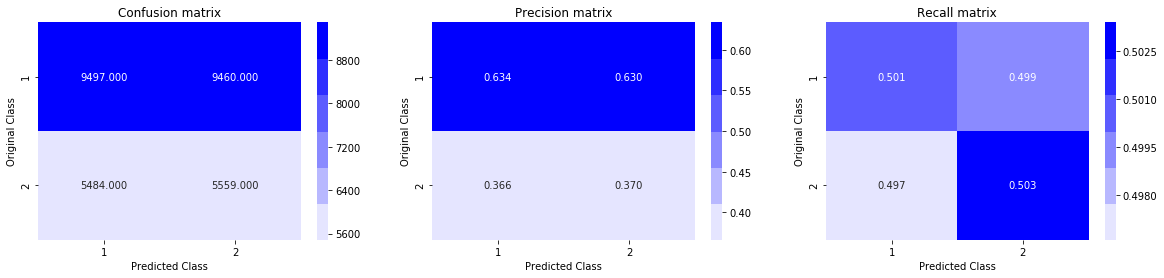

In [0]:
predicted_y = np.zeros((test_len,2))
for i in range(test_len):
    rand_probs = np.random.rand(1,2)
    predicted_y[i] = ((rand_probs/sum(sum(rand_probs)))[0])
print("Log loss on Test Data using Random Model",log_loss(y_test, predicted_y, eps=1e-15))

predicted_y =np.argmax(predicted_y, axis=1)
plot_confusion_matrix(y_test, predicted_y)

Confusion Matrix:

Precision Matrix - Column sum equals 1. Diagnol values are the values of precision matrix.

Recall - Row sums to 1. Diagnol values are the recall values of class 1 and class 2.

SInce more points belonging to class 1 we have more value categorized for class 1 than 2.

When compute log loss on random model, it will give us the dumb log loss which we can consider as the worst pecentage for a model. Any model which gives a result ranging between 0 and 0.88 can be selected as a better model and closer to 0 the better it is. To understand the worst case of our model, we calculate the loss using a dumb random model.

<h2> Logistic Regression with hyperparameter tuning</h2>

For values of alpha =  1e-05 The log loss is: 0.6579367221416667
For values of alpha =  0.0001 The log loss is: 0.4445563293029146
For values of alpha =  0.001 The log loss is: 0.44556536329588814
For values of alpha =  0.01 The log loss is: 0.4475161775900473
For values of alpha =  0.1 The log loss is: 0.44622099136201027
For values of alpha =  1 The log loss is: 0.478324541645522
For values of alpha =  10 The log loss is: 0.5193498044340623


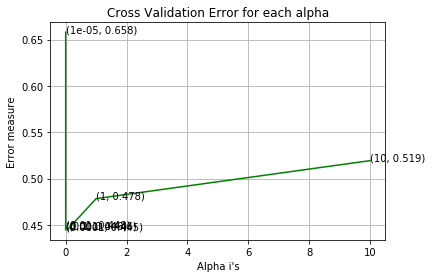

For values of best alpha =  0.0001 The train log loss is: 0.44101315266852265
For values of best alpha =  0.0001 The test log loss is: 0.4445563293029146
Total number of data points : 30000


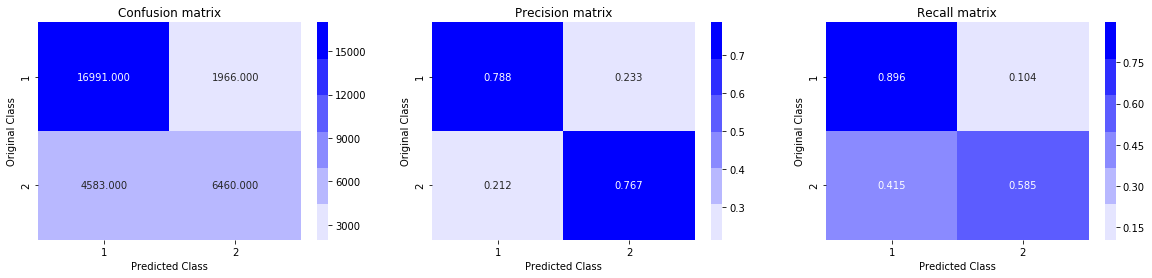

In [0]:
alpha = [10 ** x for x in range(-5, 2)] # hyperparam for SGD classifier.

log_error_array=[]
for i in alpha:
    clf = SGDClassifier(alpha=i, penalty='l2', loss='log', random_state=42)
    clf.fit(X_train, y_train)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(X_train, y_train)
    predict_y = sig_clf.predict_proba(X_test)
    log_error_array.append(log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))
    print('For values of alpha = ', i, "The log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

fig, ax = plt.subplots()
ax.plot(alpha, log_error_array,c='g')
for i, txt in enumerate(np.round(log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(X_train, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(X_train, y_train)

predict_y = sig_clf.predict_proba(X_train)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(X_test)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))
predicted_y =np.argmax(predict_y,axis=1)
print("Total number of data points :", len(predicted_y))
plot_confusion_matrix(y_test, predicted_y)

Logistic regression performs quite well on our dataset in order to solve our classification problem.

We build different models to choose the one with low log loss value. Below we have handled using SVM.

For values of alpha =  1e-05 The log loss is: 0.6579367221416667
For values of alpha =  0.0001 The log loss is: 0.6579367221416667
For values of alpha =  0.001 The log loss is: 0.6579367221416667
For values of alpha =  0.01 The log loss is: 0.5846500687948442
For values of alpha =  0.1 The log loss is: 0.6350256236615691
For values of alpha =  1 The log loss is: 0.640712148064595
For values of alpha =  10 The log loss is: 0.6529349102135013


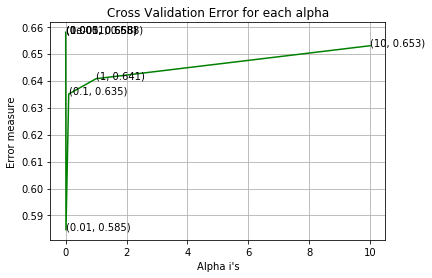

For values of best alpha =  0.01 The train log loss is: 0.5835631815907587
For values of best alpha =  0.01 The test log loss is: 0.5846500687948442
Total number of data points : 30000


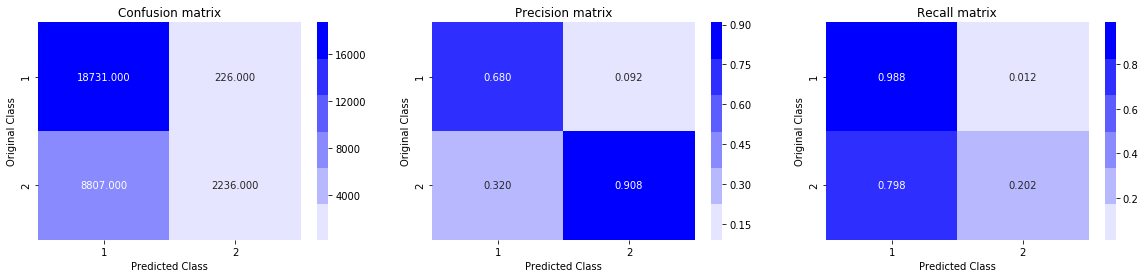

In [0]:
#SVM Model

alpha = [10 ** x for x in range(-5, 2)] # hyperparam for SGD classifier.

log_error_array=[]
for i in alpha:
    clf = SGDClassifier(alpha=i, penalty='l1', loss='hinge', random_state=42)
    clf.fit(X_train, y_train)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(X_train, y_train)
    predict_y = sig_clf.predict_proba(X_test)
    log_error_array.append(log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))
    print('For values of alpha = ', i, "The log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

fig, ax = plt.subplots()
ax.plot(alpha, log_error_array,c='g')
for i, txt in enumerate(np.round(log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l1', loss='hinge', random_state=42)
clf.fit(X_train, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(X_train, y_train)

predict_y = sig_clf.predict_proba(X_train)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(X_test)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))
predicted_y =np.argmax(predict_y,axis=1)
print("Total number of data points :", len(predicted_y))
plot_confusion_matrix(y_test, predicted_y)

Best Alpha value of 0.01 which results in merely close train and test log loss. The close difference between train and test log loss could also be a sign that our model may Underfit.

So, to eliminate this problem and build a better model with low log loss, We try out XGBoost algorithm as shown below.

In [0]:
import xgboost as xgb
params = {}
params['objective'] = 'binary:logistic'
params['eval_metric'] = 'logloss'
params['eta'] = 0.02
params['max_depth'] = 4

d_train = xgb.DMatrix(X_train, label=y_train)
d_test = xgb.DMatrix(X_test, label=y_test)

watchlist = [(d_train, 'train'), (d_test, 'valid')]

bst = xgb.train(params, d_train, 400, watchlist, early_stopping_rounds=20, verbose_eval=10)

xgdmat = xgb.DMatrix(X_train,y_train)
predict_y = bst.predict(d_test)
print("The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

[0]	train-logloss:0.684902	valid-logloss:0.685002
Multiple eval metrics have been passed: 'valid-logloss' will be used for early stopping.

Will train until valid-logloss hasn't improved in 20 rounds.
[10]	train-logloss:0.615267	valid-logloss:0.616093
[20]	train-logloss:0.564212	valid-logloss:0.565517
[30]	train-logloss:0.525768	valid-logloss:0.52743
[40]	train-logloss:0.496034	valid-logloss:0.497921
[50]	train-logloss:0.472967	valid-logloss:0.475058
[60]	train-logloss:0.454736	valid-logloss:0.456998
[70]	train-logloss:0.44024	valid-logloss:0.442554
[80]	train-logloss:0.428334	valid-logloss:0.430819
[90]	train-logloss:0.418743	valid-logloss:0.421371
[100]	train-logloss:0.410576	valid-logloss:0.41331
[110]	train-logloss:0.403804	valid-logloss:0.406635
[120]	train-logloss:0.398165	valid-logloss:0.401088
[130]	train-logloss:0.393408	valid-logloss:0.396343
[140]	train-logloss:0.389474	valid-logloss:0.39249
[150]	train-logloss:0.386055	valid-logloss:0.389194
[160]	train-logloss:0.382934	val

Total number of data points : 30000


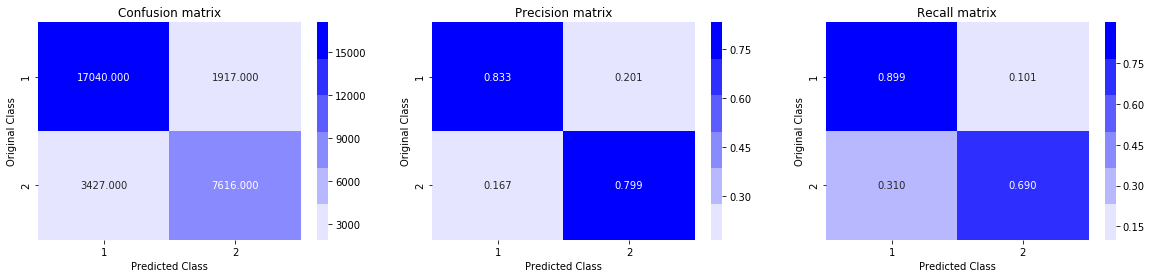

In [0]:
predicted_y =np.array(predict_y>0.5,dtype=int)
print("Total number of data points :", len(predicted_y))
plot_confusion_matrix(y_test, predicted_y)

The XGBoost seems to perform much better than other models and also resulting in a very low log loss value compared with Logistoc regressor and SVM models. 

Low the log loss, better the model performance and also validating the confusion matrix, both true positive and true negative classification were more than 65% with respect to precision and recall matrix which tells us that the model is at its best in classifying the data points.